<img src="https://github.com/pmservice/ai-openscale-tutorials/raw/master/notebooks/images/banner.png" align="left" alt="banner">

# Working with Watson Machine Learning

This notebook should be run in a Watson Studio project, using **Default Python 3.6** runtime environment. It requires service credentials for the following Cloud services:
  * Watson OpenScale
  * Watson Machine Learning
  
If you have a paid Cloud account, you may also provision a **Databases for PostgreSQL** or **Db2 Warehouse** service to take full advantage of integration with Watson Studio and continuous learning services. If you choose not to provision this paid service, you can use the free internal PostgreSQL storage with OpenScale, but will not be able to configure continuous learning for your model.

The notebook will train, create and deploy a German Credit Risk model, configure OpenScale to monitor that deployment, and inject seven days' worth of historical records and measurements for viewing in the OpenScale Insights dashboard.

### Contents

- [Setup](#setup)
- [Model building and deployment](#model)
- [OpenScale configuration](#openscale)
- [Quality monitor and feedback logging](#quality)
- [Fairness monitoring and explanations](#fairness)
- [Drift monitoring](#drift)
- [Custom monitors and metrics](#custom)
- [Payload analytics](#analytics)
- [Business application](#application)
- [Historical data](#historical)
- [Run Business Application](#run_application)

# Setup <a name="setup"></a>

## Package installation

In [1]:
!pip install --upgrade ibm-ai-openscale --no-cache | tail -n 1
!pip install lime --no-cache | tail -n 1

## Provision services and configure credentials

If you have not already, provision an instance of IBM Watson OpenScale using the [OpenScale link in the Cloud catalog](https://cloud.ibm.com/catalog/services/watson-openscale).

Your Cloud API key can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below.

**NOTE:** You can also get OpenScale `API_KEY` using IBM CLOUD CLI.

How to install IBM Cloud (bluemix) console: [instruction](https://console.bluemix.net/docs/cli/reference/ibmcloud/download_cli.html#install_use)

How to get api key using console:
```
bx login --sso
bx iam api-key-create 'my_key'
```

In [2]:
CLOUD_API_KEY = "PASTE HERE"

In [3]:
# The code was removed by Watson Studio for sharing.

Next you will need credentials for Watson Machine Learning. If you already have a WML instance, you may use credentials for it. To provision a new Lite instance of WML, use the [Cloud catalog](https://cloud.ibm.com/catalog/services/machine-learning), give your service a name, and click **Create**. Once your instance is created, click the **Service Credentials** link on the left side of the screen. Click the **New credential** button, give your credentials a name, and click **Add**. Your new credentials can be accessed by clicking the **View credentials** button. Copy and paste your WML credentials into the cell below.

In [4]:
WML_CREDENTIALS = {
    "apikey": "key",
    "iam_apikey_description": "description",
    "iam_apikey_name": "auto-generated-apikey",
    "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
    "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::",
    "instance_id": "instance_id",
    "password": "password",
    "url": "https://us-south.ml.cloud.ibm.com",
    "username": "username"
}

In [5]:
# The code was removed by Watson Studio for sharing.

This tutorial can use Databases for PostgreSQL, Db2 Warehouse, or a free internal verison of PostgreSQL to create a datamart for OpenScale.

If you have previously configured OpenScale, it will use your existing datamart, and not interfere with any models you are currently monitoring. Do not update the cell below.

If you do not have a paid Cloud account or would prefer not to provision this paid service, you may use the free internal PostgreSQL service with OpenScale. Do not update the cell below.

To provision a new instance of Db2 Warehouse, locate [Db2 Warehouse in the Cloud catalog](https://cloud.ibm.com/catalog/services/db2-warehouse), give your service a name, and click **Create**. Once your instance is created, click the **Service Credentials** link on the left side of the screen. Click the **New credential** button, give your credentials a name, and click **Add**. Your new credentials can be accessed by clicking the **View credentials** button. Copy and paste your Db2 Warehouse credentials into the cell below.

To provision a new instance of Databases for PostgreSQL, locate [Databases for PostgreSQL in the Cloud catalog](https://cloud.ibm.com/catalog/services/databases-for-postgresql), give your service a name, and click **Create**. Once your instance is created, click the **Service Credentials** link on the left side of the screen. Click the **New credential** button, give your credentials a name, and click **Add**. Your new credentials can be accessed by clicking the **View credentials** button. Copy and paste your Databases for PostgreSQL credentials into the cell below.

In [6]:
DB_CREDENTIALS = None

__If you previously configured OpenScale to use the free internal version of PostgreSQL, you can switch to a new datamart using a paid database service.__ If you would like to delete the internal PostgreSQL configuration and create a new one using service credentials supplied in the cell above, set the __KEEP_MY_INTERNAL_POSTGRES__ variable below to __False__ below. In this case, the notebook will remove your existing internal PostgreSQL datamart and create a new one with the supplied credentials. __*NO DATA MIGRATION WILL OCCUR.*__

In [8]:
KEEP_MY_INTERNAL_POSTGRES = True

## Run the notebook

At this point, the notebook is ready to run. You can either run the cells one at a time, or click the **Kernel** option above and select **Restart and Run All** to run all the cells.

# Model building and deployment <a name="model"></a>

In this section you will learn how to train Scikit-learn model and next deploy it as web-service using Watson Machine Learning service.

## Load the training data from github

In [9]:
!rm german_credit_data_biased_training.csv
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/german_credit_data_biased_training.csv

--2020-01-31 13:19:47--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/german_credit_data_biased_training.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 689622 (673K) [text/plain]
Saving to: ‘german_credit_data_biased_training.csv’

100%[======================================>] 689,622     --.-K/s   in 0.03s   

2020-01-31 13:19:47 (22.1 MB/s) - ‘german_credit_data_biased_training.csv’ saved [689622/689622]



In [10]:
import numpy as np
import pandas as pd

data_df = pd.read_csv('german_credit_data_biased_training.csv')

## Explore data

In [11]:
data_df.head()

,CheckingStatus,LoanDuration,CreditHistory,LoanPurpose,LoanAmount,ExistingSavings,EmploymentDuration,InstallmentPercent,Sex,OthersOnLoan,...,OwnsProperty,Age,InstallmentPlans,Housing,ExistingCreditsCount,Job,Dependents,Telephone,ForeignWorker,Risk
0,0_to_200,31,credits_paid_to_date,other,1889,100_to_500,less_1,3,female,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
1,less_0,18,credits_paid_to_date,car_new,462,less_100,1_to_4,2,female,none,...,savings_insurance,37,stores,own,2,skilled,1,none,yes,No Risk
2,less_0,15,prior_payments_delayed,furniture,250,less_100,1_to_4,2,male,none,...,real_estate,28,none,own,2,skilled,1,yes,no,No Risk
3,0_to_200,28,credits_paid_to_date,retraining,3693,less_100,greater_7,3,male,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
4,no_checking,28,prior_payments_delayed,education,6235,500_to_1000,greater_7,3,male,none,...,unknown,57,none,own,2,skilled,1,none,yes,Risk


In [12]:
print('Columns: ', list(data_df.columns))
print('Number of columns: ', len(data_df.columns))

Columns:  ['CheckingStatus', 'LoanDuration', 'CreditHistory', 'LoanPurpose', 'LoanAmount', 'ExistingSavings', 'EmploymentDuration', 'InstallmentPercent', 'Sex', 'OthersOnLoan', 'CurrentResidenceDuration', 'OwnsProperty', 'Age', 'InstallmentPlans', 'Housing', 'ExistingCreditsCount', 'Job', 'Dependents', 'Telephone', 'ForeignWorker', 'Risk']
Number of columns:  21


As you can see, the data contains twenty one fields. `Risk` field is the one you would like to predict using feedback data.

In [13]:
print('Number of records: ', data_df.Risk.count())

Number of records:  5000


In [14]:
target_count = data_df.groupby('Risk')['Risk'].count()
target_count

Risk
No Risk    3330
Risk       1670
Name: Risk, dtype: int64

## Visualize data

In [15]:
target_count.plot.pie(figsize=(8, 8));

## Create a model
In this section you will learn how to:

- Prepare data for training a model
- Create machine learning pipeline
- Train a model

In [16]:
MODEL_NAME = "Scikit German Risk Model"
DEPLOYMENT_NAME = "Scikit German Risk Deployment"

### You will start with importing required libraries

In [17]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

### Splitting the data into train and test

In [18]:
train_data, test_data = train_test_split(data_df, test_size=0.2)

### Preparing the pipeline

In [19]:
features_idx = np.s_[0:-1]
all_records_idx = np.s_[:]
first_record_idx = np.s_[0]

In this step you will encode target column labels into numeric values. You can use `inverse_transform` to decode numeric predictions into labels.

In [20]:
string_fields = [type(fld) is str for fld in train_data.iloc[first_record_idx, features_idx]]
ct = ColumnTransformer([("ohe", OneHotEncoder(), list(np.array(train_data.columns)[features_idx][string_fields]))])
clf_linear = SGDClassifier(loss='log', penalty='l2', max_iter=1000, tol=1e-5)

pipeline_linear = Pipeline([('ct', ct), ('clf_linear', clf_linear)])

### Train a model

In [21]:
risk_model = pipeline_linear.fit(train_data.drop('Risk', axis=1), train_data.Risk)

### Evaluate the model

In [22]:
from sklearn.metrics import roc_auc_score

predictions = risk_model.predict(test_data.drop('Risk', axis=1))
indexed_preds = [0 if prediction=='No Risk' else 1 for prediction in predictions]

real_observations = test_data.Risk.replace('Risk', 1)
real_observations = real_observations.replace('No Risk', 0).values

auc = roc_auc_score(real_observations, indexed_preds)
print(auc)

0.7349878913224089


## Publish the model

In this section, the notebook uses the supplied Watson Machine Learning credentials to save the model (including the pipeline) to the WML instance. Previous versions of the model are removed so that the notebook can be run again, resetting all data for another demo.

In [23]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient
import json

wml_client = WatsonMachineLearningAPIClient(WML_CREDENTIALS)

### Remove existing model and deployment

In [24]:
model_deployment_ids = wml_client.deployments.get_uids()
for deployment_id in model_deployment_ids:
    deployment = wml_client.deployments.get_details(deployment_id)
    model_id = deployment['entity']['deployable_asset']['guid']
    if deployment['entity']['name'] == DEPLOYMENT_NAME:
        print('Deleting deployment id', deployment_id)
        wml_client.deployments.delete(deployment_id)
        print('Deleting model id', model_id)
        wml_client.repository.delete(model_id)
wml_client.repository.list_models()

Deleting deployment id 2be20383-a05a-4315-aca5-f7dd0f552582
Deleting model id 4ef8cc15-4129-49b9-9fb6-f6992ffe8a85
----  ----  -------  ---------
GUID  NAME  CREATED  FRAMEWORK
----  ----  -------  ---------


In [25]:
model_props = {
    wml_client.repository.ModelMetaNames.NAME: "{}".format(MODEL_NAME),
    wml_client.repository.ModelMetaNames.EVALUATION_METHOD: "binary",
    wml_client.repository.ModelMetaNames.EVALUATION_METRICS: [
        {
           "name": "areaUnderROC",
           "value": auc,
           "threshold": 0.7
        }
    ]
}

In [26]:
wml_models = wml_client.repository.get_details()
model_uid = None
for model_in in wml_models['models']['resources']:
    if MODEL_NAME == model_in['entity']['name']:
        model_uid = model_in['metadata']['guid']
        break

if model_uid is None:
    print("Storing model ...")

    published_model_details = wml_client.repository.store_model(model=risk_model, meta_props=model_props, training_data=data_df.drop(['Risk'], axis=1), training_target=data_df.Risk)
    model_uid = wml_client.repository.get_model_uid(published_model_details)
    print("Done")

Storing model ...
Done


In [27]:
model_uid

'4034d109-a06d-4919-8bd2-01658aea8792'

## Deploy the model

The next section of the notebook deploys the model as a RESTful web service in Watson Machine Learning. The deployed model will have a scoring URL you can use to send data to the model for predictions.

In [29]:
wml_deployments = wml_client.deployments.get_details()
deployment_uid = None
for deployment in wml_deployments['resources']:
    if DEPLOYMENT_NAME == deployment['entity']['name']:
        deployment_uid = deployment['metadata']['guid']
        break

if deployment_uid is None:
    print("Deploying model...")

    deployment = wml_client.deployments.create(artifact_uid=model_uid, name=DEPLOYMENT_NAME, asynchronous=False)
    deployment_uid = wml_client.deployments.get_uid(deployment)
    
print("Model id: {}".format(model_uid))
print("Deployment id: {}".format(deployment_uid))

Deploying model...


#######################################################################################

Synchronous deployment creation for uid: '4034d109-a06d-4919-8bd2-01658aea8792' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='9c73141e-6197-4e29-ac94-794554f76477'
------------------------------------------------------------------------------------------------


Model id: 4034d109-a06d-4919-8bd2-01658aea8792
Deployment id: 9c73141e-6197-4e29-ac94-794554f76477


## Score the model

In [30]:
fields = ["CheckingStatus", "LoanDuration", "CreditHistory", "LoanPurpose", "LoanAmount", "ExistingSavings",
                  "EmploymentDuration", "InstallmentPercent", "Sex", "OthersOnLoan", "CurrentResidenceDuration",
                  "OwnsProperty", "Age", "InstallmentPlans", "Housing", "ExistingCreditsCount", "Job", "Dependents",
                  "Telephone", "ForeignWorker"]
values = [
            ["no_checking", 13, "credits_paid_to_date", "car_new", 1343, "100_to_500", "1_to_4", 2, "female", "none", 3,
             "savings_insurance", 46, "none", "own", 2, "skilled", 1, "none", "yes"],
            ["no_checking", 24, "prior_payments_delayed", "furniture", 4567, "500_to_1000", "1_to_4", 4, "male", "none",
             4, "savings_insurance", 36, "none", "free", 2, "management_self-employed", 1, "none", "yes"],
        ]

scoring_payload = {"fields": fields, "values": values}

In [31]:
scoring_url = wml_client.deployments.get_scoring_url(deployment)

wml_client.deployments.score(scoring_url, scoring_payload)

{'fields': ['prediction', 'probability'],
 'values': [['No Risk', [0.685076399597548, 0.31492360040245204]],
  ['No Risk', [0.8071615490213502, 0.19283845097864982]]]}

# Configure OpenScale <a name="openscale"></a>

The notebook will now import the necessary libraries and set up a Python OpenScale client.

In [32]:
from ibm_ai_openscale import APIClient
from ibm_ai_openscale.engines import *
from ibm_ai_openscale.utils import *
from ibm_ai_openscale.supporting_classes import PayloadRecord, Feature
from ibm_ai_openscale.supporting_classes.enums import *

### Get Watson OpenScale GUID

Each instance of OpenScale has a unique ID. We can get this value using the Cloud API key specified at the beginning of the notebook.

In [33]:
import requests
from ibm_ai_openscale.utils import get_instance_guid


WOS_GUID = get_instance_guid(api_key=CLOUD_API_KEY)
WOS_CREDENTIALS = {
    "instance_guid": WOS_GUID,
    "apikey": CLOUD_API_KEY,
    "url": "https://api.aiopenscale.cloud.ibm.com"
}

if WOS_GUID is None:
    print('Watson OpenScale GUID NOT FOUND')
else:
    print(WOS_GUID)

27d2155a-b202-44ac-955e-ee20b64f6c89


In [34]:
ai_client = APIClient(aios_credentials=WOS_CREDENTIALS)
ai_client.version

'2.1.21'

## Create schema and datamart

### Set up datamart

Watson OpenScale uses a database to store payload logs and calculated metrics. If database credentials were **not** supplied above, the notebook will use the free, internal lite database. If database credentials were supplied, the datamart will be created there **unless** there is an existing datamart **and** the **KEEP_MY_INTERNAL_POSTGRES** variable is set to **True**. If an OpenScale datamart exists in Db2 or PostgreSQL, the existing datamart will be used and no data will be overwritten.

Prior instances of the German Credit model will be removed from OpenScale monitoring.

In [35]:
try:
    data_mart_details = ai_client.data_mart.get_details()
    if 'internal_database' in data_mart_details and data_mart_details['internal_database']:
        if KEEP_MY_INTERNAL_POSTGRES:
            print('Using existing internal datamart.')
        else:
            if DB_CREDENTIALS is None:
                print('No postgres credentials supplied. Using existing internal datamart')
            else:
                print('Switching to external datamart')
                ai_client.data_mart.delete(force=True)
                ai_client.data_mart.setup(db_credentials=DB_CREDENTIALS)
    else:
        print('Using existing external datamart')
except:
    if DB_CREDENTIALS is None:
        print('Setting up internal datamart')
        ai_client.data_mart.setup(internal_db=True)
    else:
        print('Setting up external datamart')
        try:
            ai_client.data_mart.setup(db_credentials=DB_CREDENTIALS)
        except:
            print('Setup failed, trying Db2 setup')
            ai_client.data_mart.setup(db_credentials=DB_CREDENTIALS, schema=DB_CREDENTIALS['username'])
    

Using existing external datamart


In [36]:
data_mart_details = ai_client.data_mart.get_details()

## Bind machine learning engines

Watson OpenScale needs to be bound to the Watson Machine Learning instance to capture payload data into and out of the model. If this binding already exists, this code will output a warning message and use the existing binding.

**Note:** You can bind more than one engine instance if needed by calling `ai_client.data_mart.bindings.add` method. Next, you can refer to particular binding using `binding_uid`.

In [37]:
binding_uid = ai_client.data_mart.bindings.add('WML instance', WatsonMachineLearningInstance(WML_CREDENTIALS))
if binding_uid is None:
    binding_uid = ai_client.data_mart.bindings.get_details()['service_bindings'][0]['metadata']['guid']
bindings_details = ai_client.data_mart.bindings.get_details()
ai_client.data_mart.bindings.list()

Warning during bind instance.
Status code: 409, body: {"errors":[{"code":"AIQCS0010W","message":"Service Binding with this id is already defined"}],"trace":"MmM0YTlkYjctYWMwYy00MjZhLTliOTAtNzVmMzU4YzlhMzZi"}


e2cde82b-8a94-4d97-9d46-2288dd99c3af,WML instance,watson_machine_learning,2020-01-28T10:59:02.645Z


In [38]:
print(binding_uid)

e2cde82b-8a94-4d97-9d46-2288dd99c3af


In [39]:
ai_client.data_mart.bindings.list_assets()

4034d109-a06d-4919-8bd2-01658aea8792,Scikit German Risk Model,2020-01-31T13:20:11.978Z,model,scikit-learn-0.20,e2cde82b-8a94-4d97-9d46-2288dd99c3af,False


## Subscriptions

### Remove existing credit risk subscriptions

This code removes previous subscriptions to the German Credit model to refresh the monitors with the new model and new data.

In [40]:
subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
for subscription in subscriptions_uids:
    sub_name = ai_client.data_mart.subscriptions.get_details(subscription)['entity']['asset']['name']
    if sub_name == MODEL_NAME:
        ai_client.data_mart.subscriptions.delete(subscription)
        print('Deleted existing subscription for', MODEL_NAME)

Deleted existing subscription for Scikit German Risk Model


This code creates the model subscription in OpenScale using the Python client API. Note that we need to provide the model unique identifier, and some information about the model itself.

In [41]:
subscription = ai_client.data_mart.subscriptions.add(WatsonMachineLearningAsset(
    model_uid,
    problem_type=ProblemType.BINARY_CLASSIFICATION,
    input_data_type=InputDataType.STRUCTURED,
    label_column='Risk',
    transaction_id_column='transaction_id',
    prediction_column='prediction',
    probability_column='probability',
    feature_columns = ["CheckingStatus","LoanDuration","CreditHistory","LoanPurpose","LoanAmount","ExistingSavings","EmploymentDuration","InstallmentPercent","Sex","OthersOnLoan","CurrentResidenceDuration","OwnsProperty","Age","InstallmentPlans","Housing","ExistingCreditsCount","Job","Dependents","Telephone","ForeignWorker"],
    categorical_columns = ["CheckingStatus","CreditHistory","LoanPurpose","ExistingSavings","EmploymentDuration","Sex","OthersOnLoan","OwnsProperty","InstallmentPlans","Housing","Job","Telephone","ForeignWorker"],
    training_data_reference = {'connection': {'database_name': 'BLUDB',
                                              'hostname': 'dashdb-txn-sbox-yp-dal09-03.services.dal.bluemix.net',
                                              'password': 'khhz72v+6mcwwkfv',
                                              'username': 'cmb91569'},
                                             'location': {'schema_name': 'CMB91569',
                                              'table_name': 'CREDIT_RISK_TRAIN_DATA'},
                                             'type': 'db2'}
    
))

if subscription is None:
    print('Subscription already exists; get the existing one')
    subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
    for sub in subscriptions_uids:
        if ai_client.data_mart.subscriptions.get_details(sub)['entity']['asset']['name'] == MODEL_NAME:
            subscription = ai_client.data_mart.subscriptions.get(sub)

Get subscription list

In [42]:
subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
ai_client.data_mart.subscriptions.list()

cf423917-4e36-499b-be86-86729c7f974f,Scikit German Risk Model,model,e2cde82b-8a94-4d97-9d46-2288dd99c3af,2020-01-31T13:20:32.502Z


In [43]:
subscription_details = subscription.get_details()

### Score the model so we can configure monitors

Now that the WML service has been bound and the subscription has been created, we need to send a request to the model before we configure OpenScale. This allows OpenScale to create a payload log in the datamart with the correct schema, so it can capture data coming into and out of the model. First, the code gets the model deployment's endpoint URL, and then sends a few records for predictions.

In [44]:
credit_risk_scoring_endpoint = None
print(deployment_uid)

for deployment in wml_client.deployments.get_details()['resources']:
    if deployment_uid in deployment['metadata']['guid']:
        credit_risk_scoring_endpoint = deployment['entity']['scoring_url']
        
print(credit_risk_scoring_endpoint)

9c73141e-6197-4e29-ac94-794554f76477
https://us-south.ml.cloud.ibm.com/v3/wml_instances/e2cde82b-8a94-4d97-9d46-2288dd99c3af/deployments/9c73141e-6197-4e29-ac94-794554f76477/online


In [45]:
fields = ["CheckingStatus","LoanDuration","CreditHistory","LoanPurpose","LoanAmount","ExistingSavings","EmploymentDuration","InstallmentPercent","Sex","OthersOnLoan","CurrentResidenceDuration","OwnsProperty","Age","InstallmentPlans","Housing","ExistingCreditsCount","Job","Dependents","Telephone","ForeignWorker"]
values = [
  ["no_checking",13,"credits_paid_to_date","car_new",1343,"100_to_500","1_to_4",2,"female","none",3,"savings_insurance",46,"none","own",2,"skilled",1,"none","yes"],
  ["no_checking",24,"prior_payments_delayed","furniture",4567,"500_to_1000","1_to_4",4,"male","none",4,"savings_insurance",36,"none","free",2,"management_self-employed",1,"none","yes"],
  ["0_to_200",26,"all_credits_paid_back","car_new",863,"less_100","less_1",2,"female","co-applicant",2,"real_estate",38,"none","own",1,"skilled",1,"none","yes"],
  ["0_to_200",14,"no_credits","car_new",2368,"less_100","1_to_4",3,"female","none",3,"real_estate",29,"none","own",1,"skilled",1,"none","yes"],
  ["0_to_200",4,"no_credits","car_new",250,"less_100","unemployed",2,"female","none",3,"real_estate",23,"none","rent",1,"management_self-employed",1,"none","yes"],
  ["no_checking",17,"credits_paid_to_date","car_new",832,"100_to_500","1_to_4",2,"male","none",2,"real_estate",42,"none","own",1,"skilled",1,"none","yes"],
  ["no_checking",33,"outstanding_credit","appliances",5696,"unknown","greater_7",4,"male","co-applicant",4,"unknown",54,"none","free",2,"skilled",1,"yes","yes"],
  ["0_to_200",13,"prior_payments_delayed","retraining",1375,"100_to_500","4_to_7",3,"male","none",3,"real_estate",37,"none","own",2,"management_self-employed",1,"none","yes"]
]

payload_scoring = {"fields": fields,"values": values}
scoring_response = wml_client.deployments.score(credit_risk_scoring_endpoint, payload_scoring)

print('Single record scoring result:', '\n fields:', scoring_response['fields'], '\n values: ', scoring_response['values'][0])

Single record scoring result: 
 fields: ['prediction', 'probability'] 
 values:  ['No Risk', [0.685076399597548, 0.31492360040245204]]


# Quality monitoring and feedback logging <a name="quality"></a>

## Enable quality monitoring

The code below waits ten seconds to allow the payload logging table to be set up before it begins enabling monitors. First, it turns on the quality (accuracy) monitor and sets an alert threshold of 70%. OpenScale will show an alert on the dashboard if the model accuracy measurement (area under the curve, in the case of a binary classifier) falls below this threshold.

The second paramater supplied, min_records, specifies the minimum number of feedback records OpenScale needs before it calculates a new measurement. The quality monitor runs hourly, but the accuracy reading in the dashboard will not change until an additional 50 feedback records have been added, via the user interface, the Python client, or the supplied feedback endpoint.

In [46]:
time.sleep(10)
subscription.quality_monitoring.enable(threshold=0.7, min_records=50)

## Feedback logging

The code below downloads and stores enough feedback data to meet the minimum threshold so that OpenScale can calculate a new accuracy measurement. It then kicks off the accuracy monitor. The monitors run hourly, or can be initiated via the Python API, the REST API, or the graphical user interface.

In [47]:
!rm additional_feedback_data.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/additional_feedback_data.json

--2020-01-31 13:20:49--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/additional_feedback_data.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16506 (16K) [text/plain]
Saving to: ‘additional_feedback_data.json’

100%[======================================>] 16,506      --.-K/s   in 0.002s  

2020-01-31 13:20:49 (9.16 MB/s) - ‘additional_feedback_data.json’ saved [16506/16506]



In [48]:
with open('additional_feedback_data.json') as feedback_file:
    additional_feedback_data = json.load(feedback_file)
    
subscription.feedback_logging.store(additional_feedback_data['data'])

In [49]:
subscription.feedback_logging.show_table()

less_0,10,all_credits_paid_back,car_new,250,500_to_1000,4_to_7,3,male,none,2,real_estate,23,none,rent,1,skilled,1,none,yes,No Risk,2020-01-31 13:20:50.743575+00:00
no_checking,23,prior_payments_delayed,appliances,6964,100_to_500,4_to_7,4,female,none,3,car_other,39,none,own,1,skilled,1,none,yes,Risk,2020-01-31 13:20:50.743575+00:00
0_to_200,30,outstanding_credit,appliances,3464,100_to_500,greater_7,3,male,guarantor,4,savings_insurance,51,stores,free,1,skilled,1,yes,yes,Risk,2020-01-31 13:20:50.743575+00:00
no_checking,23,outstanding_credit,car_used,2681,500_to_1000,greater_7,4,male,none,3,car_other,33,stores,free,1,unskilled,1,yes,yes,No Risk,2020-01-31 13:20:50.743575+00:00
0_to_200,18,prior_payments_delayed,furniture,1673,less_100,1_to_4,2,male,none,3,car_other,30,none,own,2,skilled,1,none,yes,Risk,2020-01-31 13:20:50.743575+00:00
no_checking,44,outstanding_credit,radio_tv,3476,unknown,greater_7,4,male,co-applicant,4,unknown,60,none,free,2,skilled,2,yes,yes,Risk,2020-01-31 13:20:50.743575+00:00
less_0,8,no_credits,education,803,less_100,unemployed,1,male,none,1,savings_insurance,19,stores,rent,1,skilled,1,none,yes,No Risk,2020-01-31 13:20:50.743575+00:00
0_to_200,7,all_credits_paid_back,car_new,250,less_100,unemployed,1,male,none,1,real_estate,19,stores,rent,1,skilled,1,none,yes,No Risk,2020-01-31 13:20:50.743575+00:00
0_to_200,33,credits_paid_to_date,radio_tv,3548,100_to_500,1_to_4,3,male,none,4,car_other,28,none,own,2,skilled,1,yes,yes,Risk,2020-01-31 13:20:50.743575+00:00
no_checking,24,prior_payments_delayed,retraining,4158,100_to_500,greater_7,3,female,none,2,savings_insurance,35,stores,own,1,unskilled,2,none,yes,Risk,2020-01-31 13:20:50.743575+00:00


In [50]:
run_details = subscription.quality_monitoring.run(background_mode=False)




 Waiting for end of quality monitoring run 97da1ca3-0488-465a-af72-d53d5fb1e466 




completed

---------------------------
 Successfully finished run 
---------------------------




In [51]:
subscription.quality_monitoring.show_table()

2020-01-31 13:20:55.411000+00:00,true_positive_rate,051bdf34-c9b3-40b9-b51a-ba1d41782511,0.45454545454545453,,,model_type: original,e2cde82b-8a94-4d97-9d46-2288dd99c3af,cf423917-4e36-499b-be86-86729c7f974f,9c73141e-6197-4e29-ac94-794554f76477
2020-01-31 13:20:55.411000+00:00,area_under_roc,051bdf34-c9b3-40b9-b51a-ba1d41782511,0.7118881118881119,0.7,,model_type: original,e2cde82b-8a94-4d97-9d46-2288dd99c3af,cf423917-4e36-499b-be86-86729c7f974f,9c73141e-6197-4e29-ac94-794554f76477
2020-01-31 13:20:55.411000+00:00,precision,051bdf34-c9b3-40b9-b51a-ba1d41782511,0.8823529411764706,,,model_type: original,e2cde82b-8a94-4d97-9d46-2288dd99c3af,cf423917-4e36-499b-be86-86729c7f974f,9c73141e-6197-4e29-ac94-794554f76477
2020-01-31 13:20:55.411000+00:00,f1_measure,051bdf34-c9b3-40b9-b51a-ba1d41782511,0.6,,,model_type: original,e2cde82b-8a94-4d97-9d46-2288dd99c3af,cf423917-4e36-499b-be86-86729c7f974f,9c73141e-6197-4e29-ac94-794554f76477
2020-01-31 13:20:55.411000+00:00,accuracy,051bdf34-c9b3-40b9-b51a-ba1d41782511,0.7959183673469388,,,model_type: original,e2cde82b-8a94-4d97-9d46-2288dd99c3af,cf423917-4e36-499b-be86-86729c7f974f,9c73141e-6197-4e29-ac94-794554f76477
2020-01-31 13:20:55.411000+00:00,log_loss,051bdf34-c9b3-40b9-b51a-ba1d41782511,0.45087778906066156,,,model_type: original,e2cde82b-8a94-4d97-9d46-2288dd99c3af,cf423917-4e36-499b-be86-86729c7f974f,9c73141e-6197-4e29-ac94-794554f76477
2020-01-31 13:20:55.411000+00:00,false_positive_rate,051bdf34-c9b3-40b9-b51a-ba1d41782511,0.03076923076923077,,,model_type: original,e2cde82b-8a94-4d97-9d46-2288dd99c3af,cf423917-4e36-499b-be86-86729c7f974f,9c73141e-6197-4e29-ac94-794554f76477
2020-01-31 13:20:55.411000+00:00,area_under_pr,051bdf34-c9b3-40b9-b51a-ba1d41782511,0.7335479646404015,,,model_type: original,e2cde82b-8a94-4d97-9d46-2288dd99c3af,cf423917-4e36-499b-be86-86729c7f974f,9c73141e-6197-4e29-ac94-794554f76477
2020-01-31 13:20:55.411000+00:00,recall,051bdf34-c9b3-40b9-b51a-ba1d41782511,0.45454545454545453,,,model_type: original,e2cde82b-8a94-4d97-9d46-2288dd99c3af,cf423917-4e36-499b-be86-86729c7f974f,9c73141e-6197-4e29-ac94-794554f76477


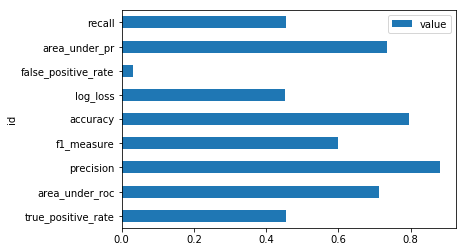

In [52]:
%matplotlib inline

quality_pd = subscription.quality_monitoring.get_table_content(format='pandas')
quality_pd.plot.barh(x='id', y='value');

# Fairness monitoring and explanations <a name="fairness"></a>

### Fairness configuration

The code below configures fairness monitoring for our model. It turns on monitoring for two features, Sex and Age. In each case, we must specify:
  * Which model feature to monitor
  * One or more **majority** groups, which are values of that feature that we expect to receive a higher percentage of favorable outcomes
  * One or more **minority** groups, which are values of that feature that we expect to receive a higher percentage of unfavorable outcomes
  * The threshold at which we would like OpenScale to display an alert if the fairness measurement falls below (in this case, 95%)

Additionally, we must specify which outcomes from the model are favourable outcomes, and which are unfavourable. We must also provide the number of records OpenScale will use to calculate the fairness score. In this case, OpenScale's fairness monitor will run hourly, but will not calculate a new fairness rating until at least 200 records have been added. Finally, to calculate fairness, OpenScale must perform some calculations on the training data, so we provide the dataframe containing the data.

In [53]:
subscription.fairness_monitoring.enable(
            features=[
                Feature("Sex", majority=['male'], minority=['female'], threshold=0.95),
                Feature("Age", majority=[[26,75]], minority=[[18,25]], threshold=0.95)
            ],
            favourable_classes=['No Risk'],
            unfavourable_classes=['Risk'],
            min_records=200,
            training_data=train_data.copy()
        )

### Drift configuration

In [54]:
subscription.drift_monitoring.enable(threshold=0.05, min_records=200)

{'config_status': {'model_name': None, 'state': 'new'},
 'data_drift_enabled': True,
 'drift_threshold': 0.05,
 'is_schedule_enabled': True,
 'min_samples': 200,
 'model_drift_enabled': True,
 'schedule_repeat_interval': 3,
 'schedule_repeat_type': 'hour'}

In [55]:
drift_status = None
while drift_status != 'finished':
    drift_details = subscription.drift_monitoring.get_details()
    drift_status = drift_details['parameters']['config_status']['state']
    if drift_status != 'finished':
        print(datetime.utcnow().strftime('%H:%M:%S'), drift_status)
        time.sleep(30)
print(drift_status)

13:21:08 new
13:21:38 in_progress
13:22:09 in_progress
13:22:39 in_progress
13:23:09 in_progress
finished


## Score the model again now that monitoring is configured

This next section randomly selects 200 records from the data feed and sends those records to the model for predictions. This is enough to exceed the minimum threshold for records set in the previous section, which allows OpenScale to begin calculating fairness.

In [58]:
from IPython.utils import io

with io.capture_output() as captured:
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/german_credit_feed.json -O german_credit_feed.json
!ls -lh german_credit_feed.json

-rw-r----- 1 dsxuser dsxuser 3.0M Jan 31 13:25 german_credit_feed.json


Score 200 randomly chosen records

In [59]:
import random

with open('german_credit_feed.json', 'r') as scoring_file:
    scoring_data = json.load(scoring_file)

fields = scoring_data['fields']
values = []
for _ in range(200):
    values.append(random.choice(scoring_data['values']))
payload_scoring = {"fields": fields, "values": values}

scoring_response = wml_client.deployments.score(credit_risk_scoring_endpoint, payload_scoring)
time.sleep(5)

**Note:** Now in payload table should be total 208 records.

In [60]:
print('Number of records in payload table: ', subscription.payload_logging.get_records_count())

Number of records in payload table:  208


## Run fairness monitor

Kick off a fairness monitor run on current data. The monitor runs hourly, but can be manually initiated using the Python client, the REST API, or the graphical user interface.

In [61]:
run_details = subscription.fairness_monitoring.run(background_mode=False)




 Counting bias for deployment_uid=9c73141e-6197-4e29-ac94-794554f76477 




RUNNING....
FINISHED

---------------------------
 Successfully finished run 
---------------------------




In [62]:
time.sleep(10)

subscription.fairness_monitoring.show_table()

2020-01-31 13:25:23.393543+00:00,Sex,female,True,0.897,69.5,e2cde82b-8a94-4d97-9d46-2288dd99c3af,cf423917-4e36-499b-be86-86729c7f974f,cf423917-4e36-499b-be86-86729c7f974f,9c73141e-6197-4e29-ac94-794554f76477,
2020-01-31 13:25:23.393543+00:00,Age,"[18, 25]",False,1.0,76.5,e2cde82b-8a94-4d97-9d46-2288dd99c3af,cf423917-4e36-499b-be86-86729c7f974f,cf423917-4e36-499b-be86-86729c7f974f,9c73141e-6197-4e29-ac94-794554f76477,


## Run drift monitor


Kick off a drift monitor run on current data. The monitor runs every hour, but can be manually initiated using the Python client, the REST API.

In [63]:
drift_run_details = subscription.drift_monitoring.run(background_mode=False)




 Waiting for end of drift monitoring run  




COMPLETED

---------------------------
 Successfully finished run 
---------------------------




In [64]:
time.sleep(5)

subscription.drift_monitoring.get_table_content()

,ts,id,measurement_id,value,lower limit,upper limit,tags,binding_id,subscription_id,deployment_id
0,2020-01-31 13:26:08.594264+00:00,data_drift_magnitude,2c116876-dfa7-4b73-aa0a-4468c5b37a46,0.086538,,,,e2cde82b-8a94-4d97-9d46-2288dd99c3af,cf423917-4e36-499b-be86-86729c7f974f,9c73141e-6197-4e29-ac94-794554f76477
1,2020-01-31 13:26:08.594264+00:00,drift_magnitude,2c116876-dfa7-4b73-aa0a-4468c5b37a46,0.022269,,0.05,,e2cde82b-8a94-4d97-9d46-2288dd99c3af,cf423917-4e36-499b-be86-86729c7f974f,9c73141e-6197-4e29-ac94-794554f76477
2,2020-01-31 13:26:08.594264+00:00,predicted_accuracy,2c116876-dfa7-4b73-aa0a-4468c5b37a46,0.772731,,,,e2cde82b-8a94-4d97-9d46-2288dd99c3af,cf423917-4e36-499b-be86-86729c7f974f,9c73141e-6197-4e29-ac94-794554f76477
3,2020-01-31 13:25:27.805258+00:00,data_drift_magnitude,0ceb7722-614e-4a3d-aaf7-04335ee2a877,0.086538,,,,e2cde82b-8a94-4d97-9d46-2288dd99c3af,cf423917-4e36-499b-be86-86729c7f974f,9c73141e-6197-4e29-ac94-794554f76477
4,2020-01-31 13:25:27.805258+00:00,drift_magnitude,0ceb7722-614e-4a3d-aaf7-04335ee2a877,0.022269,,0.05,,e2cde82b-8a94-4d97-9d46-2288dd99c3af,cf423917-4e36-499b-be86-86729c7f974f,9c73141e-6197-4e29-ac94-794554f76477
5,2020-01-31 13:25:27.805258+00:00,predicted_accuracy,0ceb7722-614e-4a3d-aaf7-04335ee2a877,0.772731,,,,e2cde82b-8a94-4d97-9d46-2288dd99c3af,cf423917-4e36-499b-be86-86729c7f974f,9c73141e-6197-4e29-ac94-794554f76477


**Note:** You can disable drift monitor running code in cell below.


## Configure Explainability

Finally, we provide OpenScale with the training data to enable and configure the explainability features.

In [65]:
from ibm_ai_openscale.supporting_classes import *

subscription.explainability.enable(training_data=data_df.copy())

In [66]:
explainability_details = subscription.explainability.get_details()

## Run explanation for sample record

In [67]:
transaction_id = subscription.payload_logging.get_table_content(limit=1)['scoring_id'].values[0]

print(transaction_id)

495ec5f1b673c2275a982b06ac43b23c-200


In [68]:
explain_run = subscription.explainability.run(transaction_id=transaction_id, background_mode=False)




 Looking for explanation for 495ec5f1b673c2275a982b06ac43b23c-200 




in_progress....
finished

---------------------------
 Successfully finished run 
---------------------------




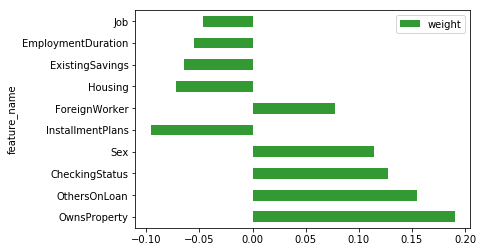

In [69]:
explain_result = pd.DataFrame.from_dict(explain_run['entity']['predictions'][0]['explanation_features'])
explain_result.plot.barh(x='feature_name', y='weight', color='g', alpha=0.8);

# Custom monitors and metrics <a name="custom"></a>

## Register custom monitor

In [70]:
def get_definition(monitor_name):
    monitors_definitions = ai_client.data_mart.monitors.get_details()['monitor_definitions']
    
    for definition in monitors_definitions:
        if monitor_name == definition['entity']['name']:
            return definition
    
    return None

In [71]:
from ibm_ai_openscale.supporting_classes import Metric, Tag

monitor_name = 'my model performance'
metrics = [Metric(name='sensitivity', lower_limit_default=0.8), Metric(name='specificity', lower_limit_default=0.75)]
tags = [Tag(name='region', description='customer geographical region')]

existing_definition = get_definition(monitor_name)

if existing_definition is None:
    my_monitor = ai_client.data_mart.monitors.add(name=monitor_name, metrics=metrics, tags=tags)
else:
    my_monitor = existing_definition

### List monitors

### Get monitors uids and details

In [72]:
monitor_uid = my_monitor['metadata']['guid']

print(monitor_uid)

my_model_performance


In [73]:
my_monitor = ai_client.data_mart.monitors.get_details(monitor_uid=monitor_uid)
print('monitor definition details', my_monitor)

monitor definition details {'entity': {'metrics': [{'expected_direction': 'increasing', 'id': 'sensitivity', 'name': 'sensitivity', 'required': True, 'thresholds': [{'default': 0.8, 'type': 'lower_limit'}]}, {'expected_direction': 'increasing', 'id': 'specificity', 'name': 'specificity', 'required': True, 'thresholds': [{'default': 0.75, 'type': 'lower_limit'}]}], 'name': 'my model performance', 'tags': [{'description': 'customer geographical region', 'id': 'region', 'name': 'region', 'required': True}]}, 'metadata': {'guid': 'my_model_performance', 'url': '/v1/data_marts/27d2155a-b202-44ac-955e-ee20b64f6c89/monitor_definitions/my_model_performance', 'created_at': '2020-01-29T14:56:07.255Z'}}


## Enable custom monitor for subscription

In [74]:
from ibm_ai_openscale.supporting_classes import Threshold

thresholds = [Threshold(metric_uid='sensitivity', lower_limit=0.9)]
subscription.monitoring.enable(monitor_uid=monitor_uid, thresholds=thresholds)

### Get monitor configuration details

In [75]:
subscription.monitoring.get_details(monitor_uid=monitor_uid)

{'enabled': True,
 'monitor_definition': {'entity': {'metrics': [{'expected_direction': 'increasing',
     'id': 'sensitivity',
     'name': 'sensitivity',
     'required': True,
     'thresholds': [{'default': 0.9, 'type': 'lower_limit'}]},
    {'expected_direction': 'increasing',
     'id': 'specificity',
     'name': 'specificity',
     'required': True}],
   'name': 'my model performance',
   'tags': [{'description': 'customer geographical region',
     'id': 'region',
     'name': 'region',
     'required': True}]},
  'metadata': {'guid': 'my_model_performance',
   'url': '/v1/data_marts/27d2155a-b202-44ac-955e-ee20b64f6c89/monitor_definitions/my_model_performance',
   'created_at': '2020-01-29T14:56:07.255Z'}},
 'thresholds': [{'metric_id': 'sensitivity',
   'type': 'lower_limit',
   'value': 0.9}]}

## Storing custom metrics

In [76]:
metrics = {"specificity": 0.78, "sensitivity": 0.67, "region": "us-south"}

subscription.monitoring.store_metrics(monitor_uid=monitor_uid, metrics=metrics)

[{'asset_id': '4034d109-a06d-4919-8bd2-01658aea8792',
  'binding_id': 'e2cde82b-8a94-4d97-9d46-2288dd99c3af',
  'measurement_id': 'b7622f0c-0bef-49db-bdc1-5f214015aac3',
  'metrics': [{'region': 'us-south',
    'sensitivity': 0.67,
    'specificity': 0.78}],
  'monitor_definition_id': 'my_model_performance',
  'subscription_id': 'cf423917-4e36-499b-be86-86729c7f974f',
  'timestamp': '2020-01-31T13:27:07.430865Z'}]

### List and get custom metrics

In [77]:
time.sleep(5)

subscription.monitoring.show_table(monitor_uid=monitor_uid)

2020-01-31 13:27:07.430865+00:00,sensitivity,b7622f0c-0bef-49db-bdc1-5f214015aac3,0.67,0.9,,region: us-south,e2cde82b-8a94-4d97-9d46-2288dd99c3af,cf423917-4e36-499b-be86-86729c7f974f,9c73141e-6197-4e29-ac94-794554f76477
2020-01-31 13:27:07.430865+00:00,specificity,b7622f0c-0bef-49db-bdc1-5f214015aac3,0.78,,,region: us-south,e2cde82b-8a94-4d97-9d46-2288dd99c3af,cf423917-4e36-499b-be86-86729c7f974f,9c73141e-6197-4e29-ac94-794554f76477


In [78]:
custom_metrics = subscription.monitoring.get_metrics(monitor_uid=monitor_uid, deployment_uid='credit')
custom_metrics

[{'asset_id': '4034d109-a06d-4919-8bd2-01658aea8792',
  'binding_id': 'e2cde82b-8a94-4d97-9d46-2288dd99c3af',
  'tags': [{'id': 'region', 'value': 'us-south'}],
  'ts': '2020-01-31T13:27:07.430865Z',
  'measurement_id': 'b7622f0c-0bef-49db-bdc1-5f214015aac3',
  'monitor_definition_id': 'my_model_performance',
  'subscription_id': 'cf423917-4e36-499b-be86-86729c7f974f',
  'metrics': [{'lower_limit': 0.9, 'id': 'sensitivity', 'value': 0.67},
   {'id': 'specificity', 'value': 0.78}]}]

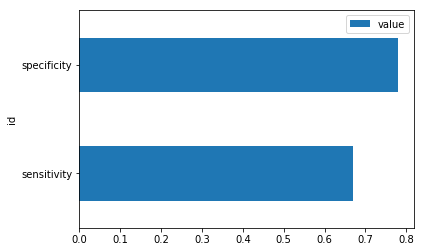

In [79]:
custom_metrics_pandas = subscription.monitoring.get_table_content(monitor_uid=monitor_uid)

%matplotlib inline
custom_metrics_pandas.plot.barh(x='id', y='value');

# Payload analytics <a name="analytics"></a>

## Run data distributions calculation

In [80]:
from datetime import datetime

start_date = "2018-01-01T00:00:00.00Z"
end_date = datetime.utcnow().isoformat() + "Z"

sex_distribution = subscription.payload_logging.data_distribution.run(
            start_date=start_date,
            end_date=end_date,
            group=['prediction', 'Sex'],
            agg=['count'])




 Waiting for end of data distribution run 3c8c38df-2bc1-4203-8955-93391694bdfe 




completed

---------------------------
 Successfully finished run 
---------------------------




## Get data distributions as pandas dataframe

In [81]:
sex_distribution_run_uid = sex_distribution['id']
distributions_pd = subscription.payload_logging.data_distribution.get_run_result(run_id=sex_distribution_run_uid, format='pandas')
distributions_pd

,prediction,Sex,count
0,No Risk,female,64
1,No Risk,male,96
2,Risk,female,6
3,Risk,male,42


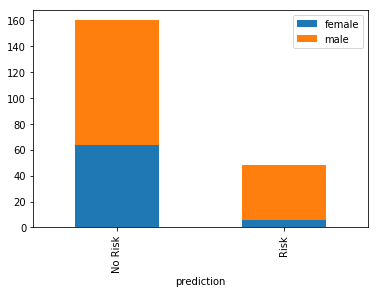

In [82]:
subscription.payload_logging.data_distribution.show_chart(sex_distribution_run_uid);

In [83]:
credit_history_distribution = subscription.payload_logging.data_distribution.run(
            start_date=start_date,
            end_date=end_date,
            group=['prediction', 'CreditHistory'],
            agg=['count'])




 Waiting for end of data distribution run db1fc058-4512-4c17-8827-c958101790ab 




completed

---------------------------
 Successfully finished run 
---------------------------




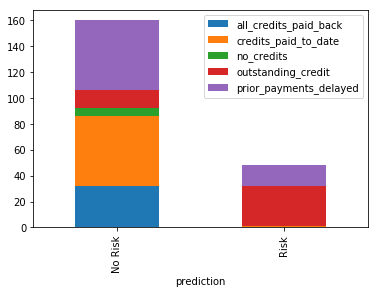

In [84]:
credit_history_distribution_run_uid = credit_history_distribution['id']

subscription.payload_logging.data_distribution.show_chart(credit_history_distribution_run_uid);

# Business Application <a name="application"></a>

In [85]:
from ibm_ai_openscale.supporting_classes import BusinessMetric, AggregationMethods

In next cells `business payload fields` and `business metrics` are desribed for aplication. `business payload fields` is a list of columns of business payload loaded at the end of section "Historical data". `business metrics` defines metrics (BKPIs) which will be calculated in created application. The application is run in [section](#run_application) after loading historical data. 

In [86]:
business_payload_fields = [
                {
                    "name": "LoanDuration",
                    "type": "number",
                    "description": "Duration of the loan"
                },
                {
                    "name": "LoanPurpose",
                    "type": "string",
                    "description": "Purpose of the loan"
                },
                {
                    "name": "LoanAmount",
                    "type": "number",
                    "description": "Amount of the loan"
                },
                {
                    "name": "InstallmentPercent",
                    "type": "number",
                    "description": "Installment percents"
                },
                {
                    "name": "AcceptedPercent",
                    "type": "number"
                },
                {
                    "name": "AmountGranted",
                    "type": "number",
                    "description": "Risk percent"
                },
                {
                    "name": "Accepted",
                    "type": "number",
                    "description": "Number of loans accepted"
                }
            ]

In [87]:
business_metrics = [BusinessMetric(metric_name='Accepted Credits', description="Accepted Credits Daily",
                                           field_name='Accepted', aggregation=AggregationMethods.SUM,
                                   time_unit='day', time_count=1, lower_limit=2150),
                    BusinessMetric(metric_name='Credit Amount Granted', description="Credit Amount Granted Daily",
                                   field_name='AmountGranted', aggregation=AggregationMethods.SUM,
                                   time_unit='day', time_count=1, lower_limit=5500000)]

## Add business application and get details:

In [89]:
application_details = ai_client.data_mart.applications.add(name="Tutorial Credit Risk Application",
                                                           description="Tutorial Business Application",
                                                           subscription_ids=[subscription.uid],
                                                           business_metrics=business_metrics,
                                                           payload_schema=business_payload_fields)
application_id = application_details['metadata']['id']

In [90]:
while application_details['entity']['status']['state'] == 'preparing':
    print(datetime.utcnow().strftime('%H:%M:%S'), application_details['entity']['status']['state'] )
    time.sleep(10)
    application_details = ai_client.data_mart.applications.get_details(application_id)
print("Final application status: {}".format(application_details['entity']['status']['state']) )

13:27:24 preparing
Final application status: active


# Historical data <a name="historical"></a>

In [94]:
historyDays = 7

 ## Insert historical payloads

The next section of the notebook downloads and writes historical data to the payload and measurement tables to simulate a production model that has been monitored and receiving regular traffic for the last seven days. This historical data can be viewed in the Watson OpenScale user interface. The code uses the Python and REST APIs to write this data.

In [95]:
with io.capture_output() as captured:
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/scikit-learn/history_payloads_with_transaction_id_scikit_0.json
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/scikit-learn/history_payloads_with_transaction_id_scikit_1.json
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/scikit-learn/history_payloads_with_transaction_id_scikit_2.json
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/scikit-learn/history_payloads_with_transaction_id_scikit_3.json
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/scikit-learn/history_payloads_with_transaction_id_scikit_4.json
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/scikit-learn/history_payloads_with_transaction_id_scikit_5.json
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/scikit-learn/history_payloads_with_transaction_id_scikit_6.json

!ls -lh history_payloads_with_transaction_id_scikit_*.json

-rw-r----- 1 dsxuser dsxuser 2.2M Jan 31 09:13 history_payloads_with_transaction_id_scikit_0.json
-rw-r----- 1 dsxuser dsxuser 2.2M Jan 31 09:13 history_payloads_with_transaction_id_scikit_1.json
-rw-r----- 1 dsxuser dsxuser 2.2M Jan 31 09:13 history_payloads_with_transaction_id_scikit_2.json
-rw-r----- 1 dsxuser dsxuser 2.3M Jan 31 09:13 history_payloads_with_transaction_id_scikit_3.json
-rw-r----- 1 dsxuser dsxuser 2.2M Jan 31 09:13 history_payloads_with_transaction_id_scikit_4.json
-rw-r----- 1 dsxuser dsxuser 2.2M Jan 31 09:13 history_payloads_with_transaction_id_scikit_5.json
-rw-r----- 1 dsxuser dsxuser 2.2M Jan 31 09:13 history_payloads_with_transaction_id_scikit_6.json


In [96]:
from ibm_ai_openscale.utils.inject_demo_data import DemoData
import os

historicalData = DemoData(aios_credentials=WOS_CREDENTIALS)
historical_data_path=os.getcwd()

historicalData.load_historical_scoring_payload(subscription, deployment_uid,file_path=historical_data_path, day_template="history_payloads_with_transaction_id_scikit_{}.json" )

Loading historical scoring payload...
Day 0 injection.
Daily loading finished.
Day 1 injection.
Daily loading finished.
Day 2 injection.
Daily loading finished.
Day 3 injection.
Daily loading finished.
Day 4 injection.
Daily loading finished.
Day 5 injection.
Daily loading finished.
Day 6 injection.
Daily loading finished.


In [97]:
data_mart_id = subscription.get_details()['metadata']['url'].split('/service_bindings')[0].split('marts/')[1]
print(data_mart_id)

27d2155a-b202-44ac-955e-ee20b64f6c89


In [98]:
performance_metrics_url = WOS_CREDENTIALS['url'] + subscription.get_details()['metadata']['url'].split('/service_bindings')[0] + '/metrics'
print(performance_metrics_url)

https://api.aiopenscale.cloud.ibm.com/v1/data_marts/27d2155a-b202-44ac-955e-ee20b64f6c89/metrics


## Insert historical fairness metrics

In [99]:
with io.capture_output() as captured:
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_fairness.json
!ls -lh history_fairness.json

-rw-r----- 1 dsxuser dsxuser 1.4M Jan 31 09:15 history_fairness.json


In [100]:
import datetime

with open('history_fairness.json', 'r') as history_file:
    payloads = json.load(history_file)

for day in range(historyDays):
    print('Loading day', day + 1)
    metrics = []
    
    for hour in range(24):
        score_time = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
        index = (day * 24 + hour) % len(payloads) # wrap around and reuse values if needed
        
        metric = {
            'metric_type': 'fairness',
            'binding_id': binding_uid,
            'timestamp': score_time,
            'subscription_id': model_uid,
            'asset_revision': model_uid,
            'deployment_id': deployment_uid,
            'value': payloads[index]
        }
        metrics.append(metric)
    response = requests.post(performance_metrics_url, json=metrics, headers=ai_client._get_headers())
print('Finished')

Loading day 1
Loading day 2
Loading day 3
Loading day 4
Loading day 5
Loading day 6
Loading day 7
Finished


## Insert historical debias metrics

In [101]:
with io.capture_output() as captured:
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_debias.json -O history_debias.json
!ls -lh history_debias.json

-rw-r----- 1 dsxuser dsxuser 553K Jan 31 13:28 history_debias.json


In [102]:
with open('history_debias.json', 'r') as history_file:
    payloads = json.load(history_file)

for day in range(historyDays):
    print('Loading day', day + 1)
    debias_metrics = []
    for hour in range(24):
        score_time = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
        index = (day * 24 + hour) % len(payloads) # wrap around and reuse values if needed

        debiasMetric = {
            'metric_type': 'debiased_fairness',
            'binding_id': binding_uid,
            'timestamp': score_time,
            'subscription_id': model_uid,
            'asset_revision': model_uid,
            'deployment_id': deployment_uid,
            'value': payloads[index]
        }

        debias_metrics.append(debiasMetric)
    response = requests.post(performance_metrics_url, json=debias_metrics, headers=ai_client._get_headers())
print('Finished')

Loading day 1
Loading day 2
Loading day 3
Loading day 4
Loading day 5
Loading day 6
Loading day 7
Finished


## Insert historical quality metrics

In [103]:
measurements = [0.76, 0.78, 0.68, 0.72, 0.73, 0.77, 0.80]
for day in range(historyDays):
    quality_metrics = []
    print('Day', day + 1)
    for hour in range(24):
        score_time = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
        qualityMetric = {
            'metric_type': 'quality',
            'binding_id': binding_uid,
            'timestamp': score_time,
            'subscription_id': model_uid,
            'asset_revision': model_uid,
            'deployment_id': deployment_uid,
            'value': {
                'quality': measurements[day],
                'threshold': 0.7,
                'metrics': [
                    {
                        'name': 'auroc',
                        'value': measurements[day],
                        'threshold': 0.7
                    }
                ]
            }
        }
        
        quality_metrics.append(qualityMetric)
    
    response = requests.post(performance_metrics_url, json=quality_metrics, headers=ai_client._get_headers())

print('Finished')

Day 1
Day 2
Day 3
Day 4
Day 5
Day 6
Day 7
Finished


## Insert historical confusion matrixes

In [104]:
with io.capture_output() as captured:
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_quality_metrics.json -O history_quality_metrics.json
!ls -lh history_quality_metrics.json

-rw-r----- 1 dsxuser dsxuser 79K Jan 31 13:28 history_quality_metrics.json


In [105]:
measurements_url = WOS_CREDENTIALS['url'] + subscription.get_details()['metadata']['url'].split('/service_bindings')[0] + '/measurements'
print(measurements_url)

https://api.aiopenscale.cloud.ibm.com/v1/data_marts/27d2155a-b202-44ac-955e-ee20b64f6c89/measurements


In [106]:
with open('history_quality_metrics.json') as json_file:
    records = json.load(json_file)
    
for day in range(historyDays):
    index = 0
    measurments = []
    print('Day', day + 1)
    
    for hour in range(24):
        score_time = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')

        measurement = {
            "monitor_definition_id": 'quality',
            "binding_id": subscription.binding_uid,
            "subscription_id": subscription.uid,
            "asset_id": subscription.source_uid,
            'metrics': [records[index]['metrics']],
            'sources': [records[index]['sources']],
            'timestamp': score_time
        }

        measurments.append(measurement)
        index+=1

    response = requests.post(measurements_url, json=measurments, headers=ai_client._get_headers())

print('Finished')

Day 1
Day 2
Day 3
Day 4
Day 5
Day 6
Day 7
Finished


## Insert historical performance metrics

In [107]:
for day in range(historyDays):
    performance_metrics = []
    print('Day', day + 1)
    for hour in range(24):
        score_time = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
        score_count = random.randint(60, 600)
        score_resp = random.uniform(60, 300)

        performanceMetric = {
            'metric_type': 'performance',
            'binding_id': binding_uid,
            'timestamp': score_time,
            'subscription_id': model_uid,
            'asset_revision': model_uid,
            'deployment_id': deployment_uid,
            'value': {
                'response_time': score_resp,
                'records': score_count
            }
        }
        performance_metrics.append(performanceMetric)

    response = requests.post(performance_metrics_url, json=performance_metrics, headers=ai_client._get_headers())

print('Finished')

Day 1
Day 2
Day 3
Day 4
Day 5
Day 6
Day 7
Finished


## Insert historical manual labeling

In [108]:
manual_labeling_url = WOS_CREDENTIALS['url'] + subscription.get_details()['metadata']['url'].split('/service_bindings')[0] + '/manual_labelings'
print(manual_labeling_url)

https://api.aiopenscale.cloud.ibm.com/v1/data_marts/27d2155a-b202-44ac-955e-ee20b64f6c89/manual_labelings


In [109]:
with io.capture_output() as captured:
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_manual_labeling.json -O history_manual_labeling.json
!ls -lh history_manual_labeling.json

-rw-r----- 1 dsxuser dsxuser 926K Jan 31 13:28 history_manual_labeling.json


In [110]:
with open('history_manual_labeling.json', 'r') as history_file:
    records = json.load(history_file)

for day in range(historyDays):
    print('Loading day', day + 1)
    record_json = []
    for hour in range(24):
        for record in records:
            if record['fastpath_history_day'] == day and record['fastpath_history_hour'] == hour:
                record['binding_id'] = binding_uid
                record['subscription_id'] = model_uid
                record['asset_revision'] = model_uid
                record['deployment_id'] = deployment_uid
                record['scoring_timestamp'] = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
                record_json.append(record)
    response = requests.post(manual_labeling_url, json=record_json, headers=ai_client._get_headers())

print('Finished')

Loading day 1
Loading day 2
Loading day 3
Loading day 4
Loading day 5
Loading day 6
Loading day 7
Finished


## Insert historical drift measurements

In [111]:
with io.capture_output() as captured:
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wos/history_drift_measurement_0.json
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wos/history_drift_measurement_1.json
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wos/history_drift_measurement_2.json
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wos/history_drift_measurement_3.json
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wos/history_drift_measurement_4.json
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wos/history_drift_measurement_5.json
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wos/history_drift_measurement_6.json
!ls -lh history_drift_measurement_*.json

-rw-r----- 1 dsxuser dsxuser 832K Jan 31 09:18 history_drift_measurement_0.json
-rw-r----- 1 dsxuser dsxuser 868K Jan 31 09:18 history_drift_measurement_1.json
-rw-r----- 1 dsxuser dsxuser 870K Jan 31 09:18 history_drift_measurement_2.json
-rw-r----- 1 dsxuser dsxuser 910K Jan 31 09:18 history_drift_measurement_3.json
-rw-r----- 1 dsxuser dsxuser 841K Jan 31 09:18 history_drift_measurement_4.json
-rw-r----- 1 dsxuser dsxuser 836K Jan 31 09:18 history_drift_measurement_5.json
-rw-r----- 1 dsxuser dsxuser 840K Jan 31 09:18 history_drift_measurement_6.json


In [112]:
print(measurements_url)

https://api.aiopenscale.cloud.ibm.com/v1/data_marts/27d2155a-b202-44ac-955e-ee20b64f6c89/measurements


In [113]:
for day in range(historyDays):
    measurements = []

    with open("history_drift_measurement_{}.json".format(day), 'r') as history_file:
        drift_daily_measurements = json.load(history_file)
    print('Loading day', day + 1)

    #Historical data contains 8 records per day - each represents 3 hour drift window.
    
    for nb_window, records in enumerate(drift_daily_measurements):
        for record in records:
            window_start =  (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24 * day + (nb_window+1)*3 + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ') # first_payload_record_timestamp_in_window (oldest)
            window_end = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24 * day + nb_window*3 + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')# last_payload_record_timestamp_in_window (most recent)
            #modify start and end time for each record
            record['sources'][0]['data']['start'] = window_start
            record['sources'][0]['data']['end'] = window_end
            
            measurement = {
                "monitor_definition_id": "drift",
                "binding_id": subscription.binding_uid,
                "subscription_id": subscription.uid,
                "asset_id": subscription.source_uid,
                'metrics': record['metrics'],
                'sources': record['sources'],
                'timestamp': window_start,
                'process': 'Drift run for subscription_{}'.format(subscription.uid)
            }

            measurements.append(measurement)
    response = requests.post(measurements_url, json=measurements, headers=ai_client._get_headers())
    print("Daily loading finished.")

Loading day 1
Daily loading finished.
Loading day 2
Daily loading finished.
Loading day 3
Daily loading finished.
Loading day 4
Daily loading finished.
Loading day 5
Daily loading finished.
Loading day 6
Daily loading finished.
Loading day 7
Daily loading finished.


## Insert Business payload 

Following section triggers two minute waiting for all historical records to be loaded succesfully.


In [114]:
with io.capture_output() as captured:
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_business_payloads_week.csv -O history_business_payloads_week.csv
!ls -lh history_business_payloads_week.csv

-rw-r----- 1 dsxuser dsxuser 1.6M Jan 31 13:28 history_business_payloads_week.csv


In [115]:
business_payload_data_set_id = application_details['entity']['business_payload_data_set_id']

historicalData.load_historical_business_payload(business_payload_data_set_id, file_path=historical_data_path, file_name="history_business_payloads_week.csv")
time.sleep(120)

**Note:** Now in business payload table should be total 20160 records.

In [116]:
print('Number of records in business payload table: ', ai_client.data_mart.applications.get_business_payload_records_count(application_id))

Number of records in business payload table:  20160


# Run Business Application  <a id="run_application"></a>

In [117]:
run_details = ai_client.data_mart.applications.run(application_id)

## Additional data to help debugging

In [118]:
print('Datamart:', data_mart_id)
print('Model:', model_uid)
print('Deployment:', deployment_uid)
print('Binding:', binding_uid)
print('Scoring URL:', credit_risk_scoring_endpoint)

Datamart: 27d2155a-b202-44ac-955e-ee20b64f6c89
Model: 4034d109-a06d-4919-8bd2-01658aea8792
Deployment: 9c73141e-6197-4e29-ac94-794554f76477
Binding: e2cde82b-8a94-4d97-9d46-2288dd99c3af
Scoring URL: https://us-south.ml.cloud.ibm.com/v3/wml_instances/e2cde82b-8a94-4d97-9d46-2288dd99c3af/deployments/9c73141e-6197-4e29-ac94-794554f76477/online


## Identify transactions for Explainability

Transaction IDs identified by the cells below can be copied and pasted into the Explainability tab of the OpenScale dashboard.

In [119]:
payload_data = subscription.payload_logging.get_table_content(limit=60)
payload_data.filter(items=['scoring_id', 'predictedLabel', 'probability'])

,scoring_id,probability
0,495ec5f1b673c2275a982b06ac43b23c-200,"[0.9252284604459459, 0.07477153955405412]"
1,495ec5f1b673c2275a982b06ac43b23c-199,"[0.04690428723470963, 0.9530957127652904]"
2,495ec5f1b673c2275a982b06ac43b23c-198,"[0.9382416521770496, 0.06175834782295037]"
3,495ec5f1b673c2275a982b06ac43b23c-197,"[0.6569122352669601, 0.3430877647330399]"
4,495ec5f1b673c2275a982b06ac43b23c-196,"[0.42367586199114105, 0.576324138008859]"
5,495ec5f1b673c2275a982b06ac43b23c-195,"[0.9737817478738762, 0.026218252126123855]"
6,495ec5f1b673c2275a982b06ac43b23c-194,"[0.9450355723930663, 0.0549644276069337]"
7,495ec5f1b673c2275a982b06ac43b23c-193,"[0.8350518934422186, 0.1649481065577814]"
8,495ec5f1b673c2275a982b06ac43b23c-192,"[0.4803977743649086, 0.5196022256350914]"
9,495ec5f1b673c2275a982b06ac43b23c-191,"[0.8250617516656895, 0.17493824833431051]"


## Congratulations!

You have finished the hands-on lab for IBM Watson OpenScale. You can now view the [OpenScale Dashboard](https://aiopenscale.cloud.ibm.com/). Click on the tile for the German Credit model to see fairness, accuracy, and performance monitors. Click on the timeseries graph to get detailed information on transactions during a specific time window.

## Next steps

OpenScale shows model performance over time. You have two options to keep data flowing to your OpenScale graphs:
  * Download, configure and schedule the [model feed notebook](https://raw.githubusercontent.com/emartensibm/german-credit/master/german_credit_scoring_feed.ipynb). This notebook can be set up with your WML credentials, and scheduled to provide a consistent flow of scoring requests to your model, which will appear in your OpenScale monitors.
  * Re-run this notebook. Running this notebook from the beginning will delete and re-create the model and deployment, and re-create the historical data. Please note that the payload and measurement logs for the previous deployment will continue to be stored in your datamart, and can be deleted if necessary.

## Authors

Eric Martens, is a technical specialist having expertise in analysis and description of business processes, and their translation into functional and non-functional IT requirements. He acts as the interpreter between the worlds of IT and business.

Lukasz Cmielowski, PhD, is an Automation Architect and Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.